# Введение в искусственные нейронные сети
# Урок 8. GAN

## Содержание методического пособия:


<ol>
<li>Что такое Metric Learning</li>
<li>Что такое Variational AutoEncoder (VAE)</li>
<li>Что такое Generative adversarial network</li>
<li>Общие сведения об архитектуре GAN</li>
<li>Практический пример переноса стилей изображений</li>
</ol>

## Metric Learning

Датасет Megaface
<img src='https://drive.google.com/uc?export=view&id=1iibHIVLP0cDxdO9YJO5cfbYtAyQ_xxyg'>

Задачи, которые хочется решить, используя эти данные:
1. Кто из обучающей выборки изображен на *новом* фото?
2. Один и тот же человек изображен на двух *новых* фотографиях?
3. По нескольким примерам научиться определять человека

<table>
<tr>
<td><img src='https://drive.google.com/uc?export=vies&id=1MgzghaC1HmVMZS0rAA8yblOfyoXNfJmg' width=400></td>
<td><img src='https://drive.google.com/uc?export=view&id=1obCDNWxFcccRcoQ19rBIVb4IOAk_bH50' width=300></td>
<td><img src='https://drive.google.com/uc?export=view&id=12GlZTtGFBUPgWDwi5G85R3-bvDRbSm2l'></td>
<tr>
</table>

Предпосылками появления концепта Metric Learning стали некоторые проблемы стандартой задачи классификации:
- требуется много размеченных данных для обучения
- если классов в модели становится слишком много, то может страдать качество классификации

Если взглянуть на последний слой перед классификацией, то окажется, что изображения, чьи векторы с последнего слоя оказались ближе, действительно похожи между собой. Эти векторы можем называть Embbeding'ами.

<img src='https://drive.google.com/uc?export=view&id=1AjZ_zVil1zBUq9Hogevb9L8J2eeZwDyM' width=600>

Теперь обладая знанием, что близкие эмбеддинги у тех похожих объектов, можем понять, как решать выше обозначенные задачи:

1. **Кто из обучающей выборки изображен на *новом* фото?** - Получаем у всех фотографий эмбеддинги и берем ближайших соседей по ним.
2. **Один и тот же человек изображен на двух *новых* фотографиях?** - Получаем у фотографий эмбеддинги, считаем расстояние между ними и отвечаем по отсечке.
3. **По нескольким примерам научиться определять человека** - Получаем у фотографий эмбеддинги, добавляем их в обучение KNN, для предсказания снова берем ближайших соседей.


Обучать такую модель можно с помощью специальных функций потерь, к примеру, Triplet Loss или Contrastive loss.

В случае обучения метрики, мы заставляем сеть увеличивать расстояние между фотографиями разных людей и уменьшать его между фотографиями одного и того же человека. 


**Triplet loss** - это функция потерь, где базовый вход (якорь) сравнивается с позитивным входом и с негативным. Дистанция между якорем и позитивным примером минимизируется, а расстояние между якорем и негативным максимизируется. Обучаются тройки.


**Contrastive loss** - это функция потерь, где базовый вход (якорь) сравнивается только с позитивным входом, либо только с негативнымным. Дистанция между якорем и позитивным примером минимизируется, а расстояние между якорем и негативным максимизируется. Обучаются пары.


<img src='https://drive.google.com/uc?export=view&id=1PCtuC8wagk5sBtlym6ACH1HKRaEs-6Wm'>

Если будем обучать с обычным softmax loss, то сети будет достаточно просто разделить классы между собой. Другими словами, у каждого человека есть свое пространство, в которое должны попадать все вектора его лиц. Но есть проблема - расстояние (угол) между изображениями на границах близких классов может быть меньше, чем расстояние между некоторыми изображениями одного класса.

Можно добавить между этими пространствами некоторую пустую область. Теперь между нашими классами есть пустая область, и граничные изображения одного класса далеко до изображений других классов.

<img src='https://hsto.org/webt/kp/ic/vd/kpicvd1vebzshxykvcwuapx67q4.jpeg' width=500>

Реализация функций потерь по метрикам для keras в [репозитории](https://github.com/4uiiurz1/keras-arcface).

In [ ]:
from keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                          Flatten, Dropout, Dense, GlobalAveragePooling2D,
                          Activation)
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


(X, y), (X_test, y_test_l) = mnist.load_data()

X = X[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y = to_categorical(y, 10)
y_test = to_categorical(y_test_l, 10)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
input = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), padding='same', activation='relu')(input)
x = BatchNormalization()(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(3)(x)
x = BatchNormalization()(x)
output = Dense(10, activation='softmax')(x)

softmax_model = Model(input, output)

softmax_model.compile(loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy'])
softmax_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128   

In [ ]:
softmax_model.fit(X, y, validation_data=(X_test, y_test),
                  batch_size=256,
                  epochs=5,
                  verbose=1)

Epoch 1/5
235/235 [==============================] - 21s 27ms/step - loss: 1.5144 - accuracy: 0.5821 - val_loss: 2.2460 - val_accuracy: 0.1834
Epoch 2/5
235/235 [==============================] - 4s 17ms/step - loss: 0.9926 - accuracy: 0.8225 - val_loss: 1.3076 - val_accuracy: 0.5394
Epoch 3/5
235/235 [==============================] - 4s 17ms/step - loss: 0.6676 - accuracy: 0.9096 - val_loss: 0.5652 - val_accuracy: 0.9442
Epoch 4/5
235/235 [==============================] - 4s 17ms/step - loss: 0.4684 - accuracy: 0.9454 - val_loss: 0.3322 - val_accuracy: 0.9660
Epoch 5/5
235/235 [==============================] - 4s 16ms/step - loss: 0.3452 - accuracy: 0.9571 - val_loss: 0.2634 - val_accuracy: 0.9687


Обучение с помощью метрик

In [ ]:
!git clone https://github.com/4uiiurz1/keras-arcface.git
import sys
sys.path.append('/content/keras-arcface/')

Cloning into 'keras-arcface'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.


In [ ]:
from metrics import ArcFace

input_y = Input(shape=(10,))
input = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), padding='same', activation='relu')(input)
x = BatchNormalization()(x)


x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

x = MaxPooling2D(pool_size=(2, 2))(x)

x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(3)(x)
x = BatchNormalization()(x)

output = ArcFace(10, m=1)([x, input_y])

model = Model([input, input_y], output)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 16)   160         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 28, 28, 16)  64          ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 14, 14, 16)  0           ['batch_normalization_5[0][

In [ ]:
model.fit([X, y], y, validation_data=([X_test, y_test], y_test),
          batch_size=512,
          epochs=20,
          verbose=1)

Epoch 1/20
118/118 [==============================] - 6s 32ms/step - loss: 21.8736 - accuracy: 0.0088 - val_loss: 43.1054 - val_accuracy: 0.0000e+00
Epoch 2/20
118/118 [==============================] - 3s 27ms/step - loss: 12.8668 - accuracy: 0.0521 - val_loss: 37.1746 - val_accuracy: 0.0666
Epoch 3/20
118/118 [==============================] - 3s 27ms/step - loss: 9.8092 - accuracy: 0.1578 - val_loss: 17.9627 - val_accuracy: 0.0894
Epoch 4/20
118/118 [==============================] - 3s 27ms/step - loss: 8.1208 - accuracy: 0.2286 - val_loss: 9.2625 - val_accuracy: 0.1880
Epoch 5/20
118/118 [==============================] - 3s 28ms/step - loss: 6.8558 - accuracy: 0.2675 - val_loss: 6.8052 - val_accuracy: 0.2835
Epoch 6/20
118/118 [==============================] - 3s 27ms/step - loss: 5.8005 - accuracy: 0.3433 - val_loss: 3.5608 - val_accuracy: 0.5978
Epoch 7/20
118/118 [==============================] - 3s 28ms/step - loss: 4.9695 - accuracy: 0.4409 - val_loss: 3.4088 - val_accurac

In [ ]:
arc_model = Model(input, x)
arc_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_6 (Batc  (None, 14, 14, 32)       128 

In [ ]:
embds_dict = {}

for img, label in zip(X[:50], y[:50]):
    emb = arc_model.predict(img[None])
    embds_dict[np.argmax(label)] = emb[0]

embds_dict

{0: array([-0.46011245,  1.199565  , -1.1110898 ], dtype=float32),
 1: array([-0.24560866, -1.3406245 , -0.0460122 ], dtype=float32),
 2: array([-0.6801003 ,  0.78353477,  0.39390415], dtype=float32),
 3: array([-0.9427406, -0.6227022,  1.6617461], dtype=float32),
 4: array([-0.34282136, -0.5787312 , -1.609229  ], dtype=float32),
 5: array([0.35908872, 0.55032045, 0.8878647 ], dtype=float32),
 6: array([-1.3515458 , -0.2932855 , -0.24851485], dtype=float32),
 7: array([ 0.81216073, -0.47991467, -0.5112607 ], dtype=float32),
 8: array([ 1.7546629 ,  1.4817411 , -0.53023946], dtype=float32),
 9: array([ 0.05196086, -0.04919827,  0.17012915], dtype=float32)}

Distance between 3 5 = 3.9646236896514893
Distance between 3 0 = 11.722097396850586
Distance between 3 4 = 11.377270698547363
Distance between 3 1 = 4.023102283477783
Distance between 3 9 = 3.80458664894104
Distance between 3 2 = 3.9477858543395996
Distance between 3 3 = 0.006285680923610926
Distance between 3 6 = 4.097843647003174
Distance between 3 7 = 8.137612342834473
Distance between 3 8 = 17.122758865356445


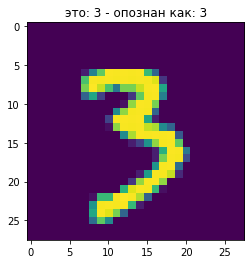

In [ ]:
N = 30
img = X_test[N:N+1]

emb = arc_model.predict(img)[0]


dists = []
for name_2, emb_2 in embds_dict.items():
    dist = np.sum(np.square(emb - emb_2))
    dists.append((dist, name_2))
    print(f"Distance between {np.argmax(y_test[N])} {name_2} = {dist}")


plt.imshow(X_test[N].reshape((28, 28)))
plt.title(f'это: {np.argmax(y_test[N])} - опознан как: {sorted(dists)[0][1]}')
plt.show()

Визуализируем эмбеддинги

313/313 [==============================] - 1s 3ms/step


Text(0.5, 0.92, 'Softmax')

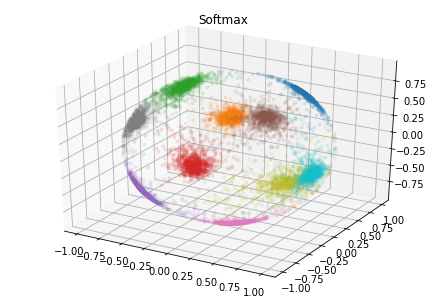

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


softmax_model = Model(inputs=softmax_model.input, outputs=softmax_model.layers[-2].output)
softmax_features = softmax_model.predict(X_test, verbose=1)
softmax_features /= np.linalg.norm(softmax_features, axis=1, keepdims=True)

fig1 = plt.figure()
ax1 = Axes3D(fig1)
for c in range(len(np.unique(y_test_l))):
    ax1.plot(softmax_features[y_test_l==c, 0],
             softmax_features[y_test_l==c, 1],
             softmax_features[y_test_l==c, 2], '.', alpha=0.1)
plt.title('Softmax')

313/313 [==============================] - 1s 3ms/step


Text(0.5, 0.92, 'ArcFace')

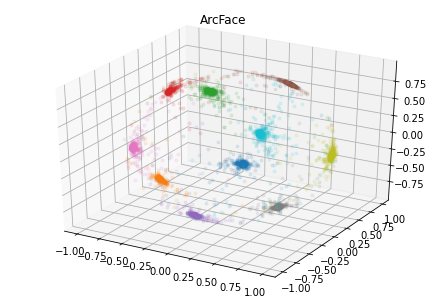

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

arcface_features = arc_model.predict(X_test, verbose=1)
arcface_features /= np.linalg.norm(arcface_features, axis=1, keepdims=True)

fig2 = plt.figure()
ax2 = Axes3D(fig2)
for c in range(len(np.unique(y_test_l))):
    ax2.plot(arcface_features[y_test_l==c, 0],
             arcface_features[y_test_l==c, 1],
             arcface_features[y_test_l==c, 2], '.', alpha=0.1)
plt.title('ArcFace')

## Variational AutoEncoder

Наши модели выучивают полезные признаки в эмбеддингах, но для этого нужно, чтобы данные были размечены, нужно знать метки классов, но и без меток классов, можно наобучать подобные информативные пространства эмбеддингов.

Мы уже знакомы с архитектурой Автоэнкодера. Данная архитектура представляет из себя набор слоев, которые сжимают входящие данные во все более маленькое представление, а также слоев, которые разжимают затем эти данные. 

Если после такой процедуры сжатия и разжатия, удается получить на выходе изначальные данные, значит в центральных слоях данной архитектуры располагается сжатое представление данных, это пространство ещё называется Latent space (скрытое пространство). Отбросив вторую, разжимающую данные, часть, можно использовать сжатые данные для различных целей.

<img src='https://drive.google.com/uc?export=view&id=1GwfDua-4m7D3sW1eycPjr58YrRkyLNc0'>


In [ ]:
28 * 28

784

Но проблема автоэнкодеров в том, что они обучаются на ограниченной выборке, в пространстве признаков у нас будут существовать описание точечно. То есть если попытаемся посдвигать вектор эмбеддинга немного, у нас не получится генерировать из него разумные картинки, потому что автоэнкодер обучался воспроизводить конкретные картинки.

Можем постараться обучить автоэкодер так, чтобы декодер генерировал картинки из любой точки нашего скрытого пространства.


**Вариационные автоэнкодеры (Variational Autoencoders)** — это автоэнкодеры, которые учатся отображать объекты в заданное скрытое пространство и, соответственно, сэмплить из него.

Такой энкодер будет выдавать не одну точку в пространстве, которая описывается одним вектором, а два вектора - среднее и дисперсию для картинки. А на вход декодеру возьмем случайную точку в предсказанном круге, по нему он должен реконструировать изображение.

Обучать нужно на двух функциях потерь:
1. Что он может восстановить из случайной точки картинку $L_r = ||x_{out} - x_{in}||^2$
2. Лосс для того, чтобы не делались слишком маленькие окружности - это метрика большая, когда распределения слишком далеко, а маленькая - когда распределения близки к друг другу $L_{KL} = D_{KL}(\mu, \sigma)$

<img src='https://drive.google.com/uc?export=view&id=1VGNYx2067ZrNDrJF-9u_QUJ0ET8CA-mL'>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1) / 255.0

img_shape = 28

**Cтроим слой семплирования sampling layer**


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

**Строим encoder**


In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(img_shape, img_shape, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2,
                  padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2,
                  padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 32)   320         ['input_8[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_10[0][0]']              
                                                                                                  
 flatten_4 (Flatten)            (None, 3136)         0           ['conv2d_11[0][0]']              
                                                                                            

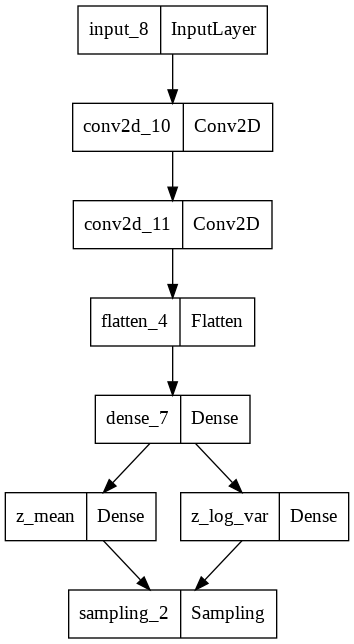

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(encoder)

**Строим свой decoder**


In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 1)        289 

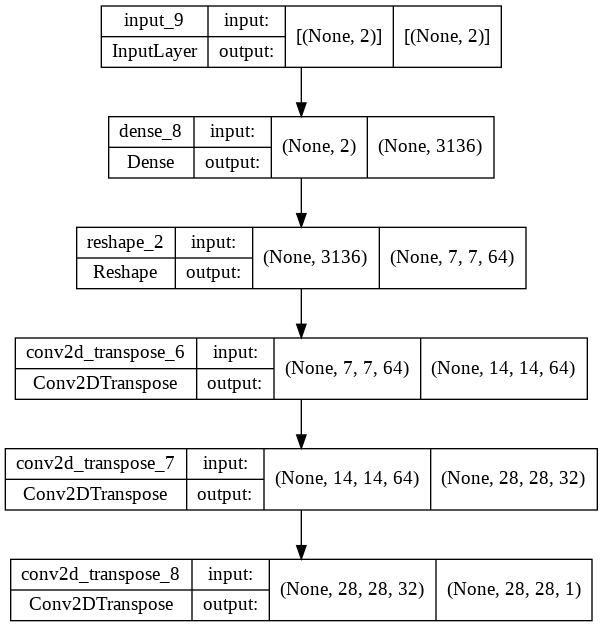

In [ ]:
plot_model(decoder, show_shapes=True)

**Создаем класс модель по `Model` с особым шагом *обучения* `train_step`**


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        # if isinstance(data, tuple):
        #     data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= img_shape * img_shape
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

**Учим VAE**


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(mnist_digits,
        epochs=12,
        batch_size=256)

Epoch 1/12
274/274 [==============================] - 9s 30ms/step - loss: 221.0589 - reconstruction_loss: 219.6621 - kl_loss: 1.3969
Epoch 2/12
274/274 [==============================] - 8s 30ms/step - loss: 172.7300 - reconstruction_loss: 170.8984 - kl_loss: 1.8317
Epoch 3/12
274/274 [==============================] - 8s 30ms/step - loss: 164.1179 - reconstruction_loss: 162.3563 - kl_loss: 1.7616
Epoch 4/12
274/274 [==============================] - 8s 30ms/step - loss: 158.6036 - reconstruction_loss: 156.8100 - kl_loss: 1.7936
Epoch 5/12
274/274 [==============================] - 8s 30ms/step - loss: 155.5739 - reconstruction_loss: 153.7305 - kl_loss: 1.8434
Epoch 6/12
274/274 [==============================] - 8s 30ms/step - loss: 153.6909 - reconstruction_loss: 151.8109 - kl_loss: 1.8800
Epoch 7/12
274/274 [==============================] - 8s 30ms/step - loss: 152.1874 - reconstruction_loss: 150.2756 - kl_loss: 1.9118
Epoch 8/12
274/274 [==============================] - 8s 30ms/

**Результат предсказания**


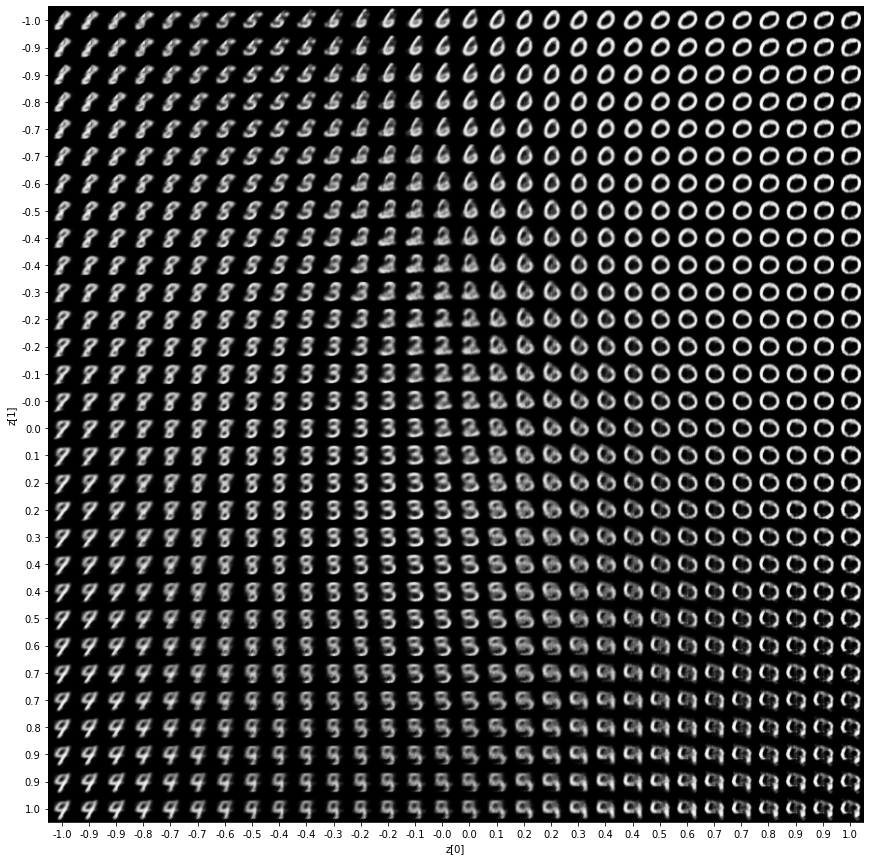

In [ ]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    """ display a n*n 2D manifold of digits """
    n = 30
    digit_size = 28
    scale = 1.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

**Посмотрим на кластеры в скрытом пространстве**


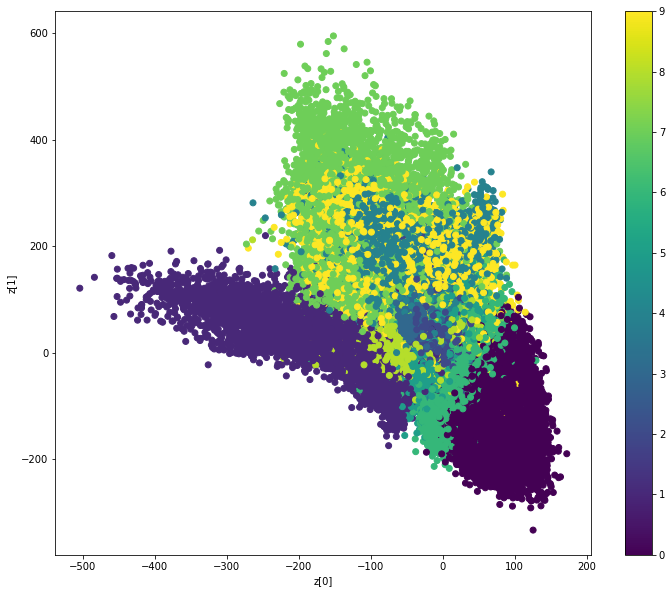

In [ ]:
def plot_label_clusters(encoder, data, labels):
    """ display a 2D plot of the digit classes in the latent space """
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, x_train, y_train)

Построим немного примеров генерации:

для этого не нужен энкодер


работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца )
- подать их в декодер
- визуализировать результат

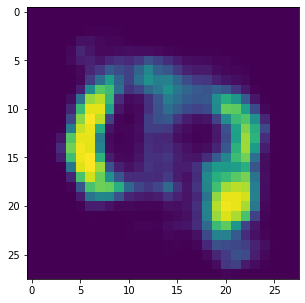

In [ ]:
def plot_digit_from_decoder(decoder, z, digit_size):
    """ display a 2D plot of the digit classes in the latent space """
    data = np.array([[z[0], z[1]]])
    digit = decoder.predict(data)
    digit = digit.reshape(digit_size, digit_size)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(digit)

    plt.show()


plot_digit_from_decoder(decoder, [1, 1], 28)

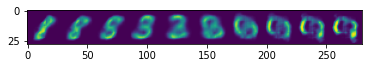

In [ ]:
n = 10
figure = np.zeros((img_shape, n * img_shape))

for i, (x, y) in enumerate(zip(np.linspace(-1, 1, n), np.linspace(-1, 1, n))):
    data = np.array([[x, y]])
    digit = decoder.predict(data)
    digit = digit.reshape(img_shape, img_shape)
    figure[:img_shape,
           i * img_shape: (i + 1) * img_shape] = digit


plt.imshow(figure);

Мы можем взять некоторое количество картинок людей с улыбкой и без улыбки усредним их и посчитаем разность в этом пространстве, а теперь можем этот вектор добавлять к другим картинкам.

<img src='https://drive.google.com/uc?export=view&id=1188YE--Jzr-arKeMQDMF8kSgyI3AAMNp'>

## GAN

GAN расшифровывается как Generative adversarial network(Генеративно-состязательная сеть). GAN появились в 2014 г. Автором данных нейронных сетей является Ian Goodfellow. Эти нейронные сети пременяются как правило для генерации изображений, а также изменения стилей изображений.


Данные нейронные сети примечательны сразу несколькими фактами:
- Они не делают заключение об уже имеющихся данных, а генерируют новые.
- В ряде популярных архитектурах GAN используется обучение без учителя.

Данные нейронные сети после своего появления стремительно прогрессируют. Если первые нейронные сети могли генерировать небольшие черно-белые изображения цифр и лиц, то сейчас данные нейронные сети могут генерирововать реалистичные фотографии не существующих людей, а также другие различные изображения в хорошем качестве.

https://thispersondoesnotexist.com


<table>
<tr>
<td><img src='https://drive.google.com/uc?export=view&id=1KYne_FQD3VAnF453tjCd3s27ACTCBbBQ'></td>
<td><img src='https://drive.google.com/uc?export=view&id=1ivcVCca31P2njeIXPwacN3crVYS5uNjs'></td>
</tr>
</talbe>

Так же данные нейронные сети могут генерирововать реалистичные фотографии не существующих котов.

https://thesecatsdonotexist.com/


<table>
<tr>
<td><img src='https://drive.google.com/uc?export=view&id=1IOE1gqBbbMIe8g5hTZu-CJxZuAUptinO'></td>
<td><img src='https://drive.google.com/uc?export=view&id=1n-gij_o3vqW7y2JqgR5bFKI_hxAkloY5'></td>
</tr>
</talbe>

Среди разновидностей GAN есть следующие:
- генерируют новые изображения
- переносят стиль изображения
- по текстовому описанию создают изображения
- по экскизу рисуют изображнеия
- улучшают качество изображения
- и др.

Пример текстого описания для генерации картинок:
<img src='https://drive.google.com/uc?export=vies&id=1OkeoqnBmzHslN6DgLIw25ramB33ieeHo' width=500>

Пример генерации картинки из контура:
<img src='https://drive.google.com/uc?export=view&id=1RLr8VDnUFoRyiu9-AlsFFPEejVPiq7ZW' width=500>

### Общие сведения об архитектуре GAN

Суть идеи в комбинации двух нейросетей, при которой одновременно работает два алгоритма “генератор” и “дискриминатор”. Первая сеть на вход получает случайный шум, после чего ей надо сгенерировать образ заданной категории. После этого, данный объект получает дискриминатор, который пытается распознать созданный образ и определить, является полученный объект реальным, или же сгенерированным.

Задача Генеративной модели – генерировать такие изображения,
которые вторая сеть – Дискриминатор, будет не в состоянии отличить от настоящих. Предполагается, что в таком соревновании, обе модели будут помогать друг другу в успешном обучении.

<img src='https://drive.google.com/uc?export=view&id=14K8No-q8MgYmpKZKazJepKhKSOjwbwHV'>

Процесс обучения таких сетей можно представить следующим образом:
1. Выбирается n примеров из датасета и m примеров от генератора.
2. Фиксируются веса генератора, обновляются параметры дискриминатора. Данный этап похож на задачу классификации, однако нет необходимости тренировать дискриминатор до сходимости.
3. Фиксируются веса дискриминатора и производится обновление
весов генератора таким образом, чтобы максимизировать ошибку дискриминатора на новых примерах, созданных генератором.
4. Этапы 1-3 повторяются до тех пор, пока дискриминатор и генератор не придут к состоянию равновесия.

## Практика

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

### Fashion_MNIST data

In [ ]:
# MNIST 
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

4431872/4422102 [==============================] - 0s 0us/step


**Строим дискриминатор**

размер карты 28x28 и бинарная классификация (настоящее изображение или генерировано).

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 128)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                     

**Строим генератор**

обратное по отношению к дискриминатору преобразование, меняем `Conv2D` на `Conv2DTranspose` .

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 28, 28, 256)      524544    
 Transpose)                                              

**Класс со своим этапом обучения `train_step`**

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в тензор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # учим дискриминатор
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # собрали метки изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим генератор
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        return {
            "d_loss": d_loss,
            "g_loss": g_loss
        }

**Callback для сохранения изображений по ходу обучения**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        fig, ax = plt.subplots(1, 3)
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            ax[i].imshow(img, cmap='gray')
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
        plt.show()

**Учим модель**

Epoch 1/3
1094/1094 [==============================] - ETA: 0s - d_loss: 0.4008 - g_loss: 1.8453

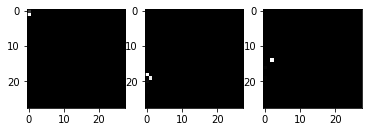

1094/1094 [==============================] - 94s 84ms/step - d_loss: 0.4004 - g_loss: 1.8480
Epoch 2/3
1094/1094 [==============================] - ETA: 0s - d_loss: 0.1695 - g_loss: 2.8624

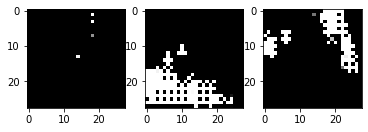

1094/1094 [==============================] - 91s 83ms/step - d_loss: 0.1694 - g_loss: 2.8625
Epoch 3/3
1094/1094 [==============================] - ETA: 0s - d_loss: 0.0331 - g_loss: 4.1758

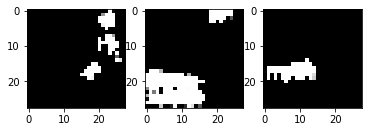

1094/1094 [==============================] - 90s 82ms/step - d_loss: 0.0331 - g_loss: 4.1768


In [ ]:
epochs = 3

gan = GAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim
)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset,
    epochs=epochs,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/3
1094/1094 [==============================] - ETA: 0s - d_loss: 0.2306 - g_loss: 3.8000

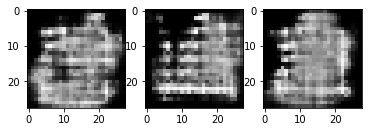

1094/1094 [==============================] - 90s 82ms/step - d_loss: 0.2312 - g_loss: 3.7972
Epoch 2/3
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6659 - g_loss: 0.9935

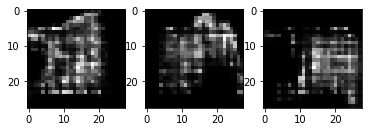

1094/1094 [==============================] - 92s 84ms/step - d_loss: 0.6657 - g_loss: 0.9936
Epoch 3/3
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6287 - g_loss: 0.9816

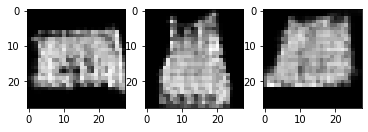

1094/1094 [==============================] - 91s 83ms/step - d_loss: 0.6287 - g_loss: 0.9813


In [ ]:
gan.fit(
    dataset,
    epochs=epochs,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

**Отобразим сгенерированные изображения**

In [ ]:
from IPython.display import Image, display

display(Image("generated_img_0_2.png"))
display(Image("generated_img_1_2.png"))
display(Image("generated_img_2_2.png"))

In [ ]:
display(Image("generated_img_2_0.png"))
display(Image("generated_img_2_1.png"))
display(Image("generated_img_2_2.png"))

### CycleGAN

В качестве практики, давайте попробуем обучить нейронную сеть превращать лошадей в зебр. Для этого нам понадобиться архитектура CycleGAN и датасет horse2zebra.

Существуют разные архитектуры GAN, такие CGAN, DCGAN, ProgressiveGAN, BigGAN, StyleBaseGan в этом уроке мы рассмотрим такую архитектуру как CycleGAN.

Она появилась в 2017 г. и была призвана генерировать объекты с определенным стилем, при условии, что в датасете у нас нет того изображения с которым мы могли бы сравнить результат. Данная нейронная сеть поэтому сначала генерирует изображение с определенным стилем, а затем возвращает его к обратному состоянию и таким образом мы получаем возможнсть контролировать результат обучения. Таким образом, в данной архитектуре используются сразу 2 GAN: одна, которая проверяет результат переноса стиля, а другая проверяет возрат к исходному изображению.

<!-- <img src='https://drive.google.com/uc?export=view&id=1WfHIKqYD3GjPiqtHRjyZbM84NXLGNZyP'> -->

<img src='https://drive.google.com/uc?export=view&id=1OR47XlddLWkksRq8FWyXcaZi7k2qvGyi' width=700>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Подключение необходимых библиотек**

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

**Предварительная обработка данных**

Нам необходимо конвертировать изображения в `286 x 286` и случайно выбранные из них обрезать до `256 x 256`. Кроме этого мы перевернем изображения горизонтально, т.е. слева на право. Таким образом мы проведем процедуру похожую на image augmentation.

Другие датасеты можно взять [здесь](https://www.tensorflow.org/datasets/catalog/cycle_gan).

In [ ]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True,
                              as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteDA9J82/cycle_gan-trainA.tfrecord


  0%|          | 0/1067 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteDA9J82/cycle_gan-trainB.tfrecord


  0%|          | 0/1334 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteDA9J82/cycle_gan-testA.tfrecord


  0%|          | 0/120 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteDA9J82/cycle_gan-testB.tfrecord


  0%|          | 0/140 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
        image, size=[IMG_HEIGHT, IMG_WIDTH, 3]
    )
    return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [ ]:
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [ ]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [ ]:
train_horses = train_horses.map(preprocess_image_train) \
                           .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.map(preprocess_image_train)\
                           .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(preprocess_image_test)\
                         .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(preprocess_image_test)\
                         .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

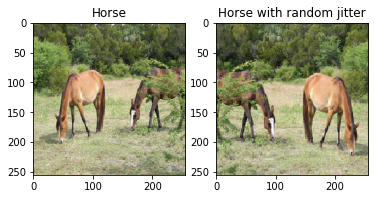

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5);

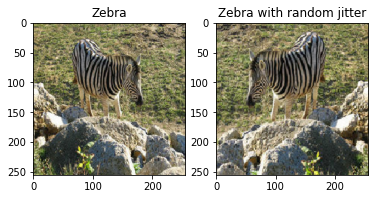

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5);

**Импортирование  Pix2Pix модели**

Генератор и дискриминатор мы возьмем из Pix2Pix модели, генерация будет осуществляться с применением Unet.

In [ ]:
OUTPUT_CHANNELS = 3

generator_to_zebra = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_to_horse = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_horse = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_zebra = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
generator_to_zebra.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   3072        ['input_12[0][0]']               
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   131328      ['sequential[0][0]']             
                                128)                                                        

In [ ]:
discriminator_horse.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 sequential_30 (Sequential)  (None, None, None, 64)    3072      
                                                                 
 sequential_31 (Sequential)  (None, None, None, 128)   131328    
                                                                 
 sequential_32 (Sequential)  (None, None, None, 256)   524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, None, None, 256)  0         
 2D)                                                             
                                                                 
 conv2d_34 (Conv2D)          (None, None, None, 512)   2097152   
                                                           

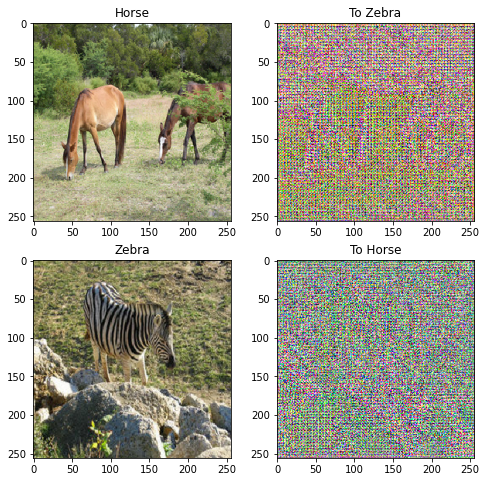

In [ ]:
to_zebra = generator_to_zebra(sample_horse)
to_horse = generator_to_horse(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

**Loss functions**

Loss функции для генератора и дискриминатора можно взять также из [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#define_the_loss_functions_and_the_optimizer).

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * loss

Инициализация оптимайзеров для всех генераторов и всех дискриминаторов.

In [ ]:
generator_to_zebra_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_to_horse_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_horse_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_zebra_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

**Checkpoints**

Сохранение промежуточных результатов, для того, чтобы при необходимости можно было продолжить обучение, а не начинать сначала.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    generator_g=generator_to_zebra,
    generator_f=generator_to_horse,
    discriminator_x=discriminator_horse,
    discriminator_y=discriminator_zebra,
    generator_g_optimizer=generator_to_zebra_optimizer,
    generator_f_optimizer=generator_to_horse_optimizer,
    discriminator_x_optimizer=discriminator_horse_optimizer,
    discriminator_y_optimizer=discriminator_zebra_optimizer
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

**Training**

In [ ]:
def generate_images(model, test_input):
    prediction = model(test_input)
        
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])

        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

Несмотря на то, что тренировочный процесс у GAN более сложный, он состоит из тех же этапов, что обычно:

* Получить предсказание
* Вычислить ошибку
* Посчитать градиенты используя обратное распространения ошибки.
* Применить градиенты для оптимайзера.

In [ ]:
def train_step(real_horse, real_zebra):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        
        fake_zebra = generator_to_zebra(real_horse, training=True)
        cycled_horse = generator_to_horse(fake_zebra, training=True)

        fake_horse = generator_to_horse(real_zebra, training=True)
        cycled_zebra = generator_to_zebra(fake_horse, training=True)

        # same_horse and same_zebra are used for identity loss.
        same_horse = generator_to_horse(real_horse, training=True)
        same_zebra = generator_to_zebra(real_zebra, training=True)

        disc_real_horse = discriminator_horse(real_horse, training=True)
        disc_real_zebra = discriminator_zebra(real_zebra, training=True)

        disc_fake_horse = discriminator_horse(fake_horse, training=True)
        disc_fake_zebra = discriminator_zebra(fake_zebra, training=True)

        # calculate the loss
        gen_to_zebra_loss = generator_loss(disc_fake_zebra)
        gen_to_horse_loss = generator_loss(disc_fake_horse)
        
        total_cycle_loss = calc_cycle_loss(real_horse, cycled_horse) \
                           + calc_cycle_loss(real_zebra, cycled_zebra)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_to_zebra_loss = gen_to_zebra_loss + \
                                  total_cycle_loss + \
                                  identity_loss(real_zebra, same_zebra)
        total_gen_to_horse_loss = gen_to_horse_loss + \
                                  total_cycle_loss + \
                                  identity_loss(real_horse, same_horse)

        disc_horse_loss = discriminator_loss(disc_real_horse, disc_fake_horse)
        disc_zebra_loss = discriminator_loss(disc_real_zebra, disc_fake_zebra)
    
    # Calculate the gradients for generator and discriminator
    generator_to_zebra_gradients = tape.gradient(
        total_gen_to_zebra_loss,
        generator_to_zebra.trainable_variables
    )
    generator_to_horse_gradients = tape.gradient(
        total_gen_to_horse_loss,
        generator_to_horse.trainable_variables
    )
    
    discriminator_horse_gradients = tape.gradient(
        disc_horse_loss, 
        discriminator_horse.trainable_variables
    )
    discriminator_zebra_gradients = tape.gradient(
        disc_zebra_loss,
        discriminator_zebra.trainable_variables
    )
    
    # Apply the gradients to the optimizer
    generator_to_zebra_optimizer.apply_gradients(
        zip(generator_to_zebra_gradients,
            generator_to_zebra.trainable_variables)
    )

    generator_to_horse_optimizer.apply_gradients(
        zip(generator_to_horse_gradients,
            generator_to_horse.trainable_variables)
    )
    
    discriminator_horse_optimizer.apply_gradients(
        zip(discriminator_horse_gradients,
            discriminator_horse.trainable_variables)
    )
    
    discriminator_zebra_optimizer.apply_gradients(
        zip(discriminator_zebra_gradients,
            discriminator_zebra.trainable_variables)
    )

In [ ]:
EPOCHS = 20

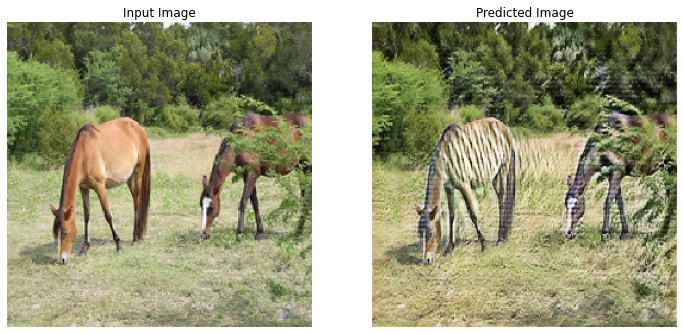

Time taken for epoch 19 is 594.664537191391 sec

....

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_horse, image_zebra in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_horse, image_zebra)
        if n % 10 == 0:
            print ('.', end='')
        n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_to_zebra, sample_horse)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Time taken for epoch {epoch + 1} is {time.time()-start} sec\n')

**Генерация из тестового датасета**

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
    generate_images(generator_to_zebra, inp)

NameError: ignored

In [ ]:
# Run the trained model on the test dataset
for inp in test_zebras.take(5):
    generate_images(generator_to_horse, inp)

## Домашнее задание к уроку

Интересные проекты с генерацией:

1. ~2min. Using latent space regression to analyze and leverage compositionality in GANs (Восстановление изображения): https://chail.github.io/latent-composition/
https://colab.research.google.com/drive/1p-L2dPMaqMyr56TYoYmBJhoyIyBJ7lzH?usp=sharing

2. ~4min. Infinite Nature: Perpetual View Generation of Natural Scenes from a Single Image (Генерация бесконечного пейзажа) https://infinite-nature.github.io/
https://colab.research.google.com/github/google-research/google-research/blob/master/infinite_nature/infinite_nature_demo.ipynb

3. ~5min. CLIP + DALL-E (Генерация изображений по словам) https://colab.research.google.com/drive/1Q-TbYvASMPRMXCOQjkxxf72CXYjR_8Vp

4. ~4min. ArtLine (Перевод картинки в скетч) https://colab.research.google.com/github/vijishmadhavan/Light-Up/blob/master/ArtLine(AR).ipynb

5. ~2min. SkyAR (Динамическая замена неба на видео) https://jiupinjia.github.io/skyar/
https://colab.research.google.com/drive/1-BqXD3EzDY6PHRdwb3cWayk2KictbFaz

Выберите любой ноутбук из примеров выше и приложите результаты работы к ДЗ.

## Дополнительные материалы

1. [Deep Learning на пальцах 8 - Metric Learning, Autoencoders, GANs
](https://youtu.be/ajEQ10s8XRg)
2. [ Автоэнкодеры в Keras, Часть 3: Вариационные автоэнкодеры (VAE) ](https://habr.com/ru/post/331552/)
3. [Variational AutoEncoder](https://keras.io/examples/generative/vae/)
4. [Deep Feature Consistent Variational Autoencoder](https://arxiv.org/abs/1610.00291)
5. [Оригинальная научная статья по GAN](https://arxiv.org/pdf/1710.07035.pdf)
6. [Оригинальная научная статья по Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
7. [Оригинальная научная статья по CycleGAN](https://arxiv.org/pdf/1703.10593.pdf)
8. [Оригинальная научная статья по Progressive GAN](https://arxiv.org/pdf/1710.10196.pdf)
9. [Оригинальная научная статья по BigGAN](https://arxiv.org/pdf/1809.11096.pdf)
10. [The GAN Zoo](https://github.com/hindupuravinash/the-gan-zoo)

## Используемая литература 

Для подготовки данного методического пособия были использованы следующие ресурсы:
<ol>
    <li>https://www.tensorflow.org/tutorials/generative/cyclegan</li>
    <li>Generative Adversarial Networks: An Overview. Antonia Creswell, Tom White, Vincent Dumoulin, Kai Arulkumaran, Biswa Sengupta, Anil A Bharath. 2017</li>    
<li>A Survey and Taxonomy of Adversarial Neural Networks for Text-to-Image Synthesis. Jorge Agnese, Jonathan Herrera, Haicheng Tao, Xingquan Zhu. 2019</li> 
    <li>Википедия</li>  
</ol>

## Определения

*Metric Learning*



**Triplet loss** — это функция потерь, где базовый вход (якорь) сравнивается с позитивным входом и с негативным. Дистанция между якорем и позитивным примером минимизируется, а расстояние между якорем и негативным максимизируется. Обучаются тройки.


**Contrastive loss** — это функция потерь, где базовый вход (якорь) сравнивается только с позитивным входом, либо только с негативнымным. Дистанция между якорем и позитивным примером минимизируется, а расстояние между якорем и негативным максимизируется. Обучаются пары.


<img src='https://drive.google.com/uc?export=view&id=1PCtuC8wagk5sBtlym6ACH1HKRaEs-6Wm'>


*VAE*

**Вариационные автоэнкодеры (Variational Autoencoders)** — это автоэнкодеры, которые учатся отображать объекты в заданное скрытое пространство и, соответственно, сэмплить из него.

*GAN*

**Генеративно-состязательная сеть (Generative adversarial network, GAN)** — алгоритм машинного обучения без учителя, построенный на комбинации из двух нейронных сетей, одна из которых генерирует образцы，а другая старается отличить правильные («подлинные») образцы от неправильных.
